## Imports

In [1]:
import os
import numpy as np
import json
import cv2
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import BatchNormalization
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

In [9]:
# Initialize variables
data = []
labels = []
height, width = 96, 96
    
# Load the OpenCV pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

## Preprocess Function

In [10]:
# Preprocess function
def preprocess(images_dir, height, width, data, labels, face_cascade, employee, max_images=175):
    saved_images = 0  # Counter for saved images
    
    # Employee-specific directory if it doesn't exist
    employee_dir = os.path.join("preprocessedData", employee)
    os.makedirs(employee_dir, exist_ok=True)

    # To stop after reaching max images
    for index, name in enumerate(os.listdir(images_dir)):
        if saved_images >= max_images:
            break
        
        image_path = os.path.join(images_dir, name)
        
        # Read images
        try:
            image = imread(image_path)
        except Exception as e:
            print(f"skimage failed to read {image_path}.")
            try:
                image = imageio.imread(image_path)
            except Exception as e:
                print(f"Failed to read {image_path} with imageio. Skipping.")
                continue
        
        # Process images and detect faces
        try:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        except Exception as e:
            print(f"Error processing {image_path}. Skipping.")
            continue

        # If at least one face is detected, crop the first face found
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            face = image[y:y+h, x:x+w]

            # Ensure the face has 3 channels (RGB)
            if face.shape[-1] != 3:
                print(f"Image {image_path} does not have 3 channels. Skipping.")
                continue

            # Resize the face
            face = cv2.resize(face, (height, width))
            
            try:
                # Save the validated image in the employee-specific folder
                save_path = os.path.join(employee_dir, f"{employee}_{index}.jpg")
                cv2.imwrite(save_path, face)
                saved_images += 1  # Increment the counter for saved images
            except Exception as e:
                print(f"Failed to save {image_path}. Skipping.")
                continue
            
            # Save in variables
            data.append(face)
            labels.append(employee)

    print(f"{employee}: {saved_images} images")

## Preprocess Data

In [11]:
# Preprocess data
employees_dir = "employees"
employees = os.listdir(employees_dir)
        
# Get images from employee directory and detect faces
for employee in employees:
    images_dir = os.path.join(employees_dir, employee)
    preprocess(images_dir, height, width, data, labels, face_cascade, employee)
            
# Saving labels
with open("labels.json", "w") as file:
    json.dump(sorted(set(labels)), file)
            
num_classes = len(set(labels))

Alexandra Daddario: 175 images
Andy Samberg: 175 images
Emilia Clarke: 175 images
Henry Cavil: 168 images
Leonardo DiCaprio: 175 images


In [21]:
# Splitting Data
X_train, X_test, y_train_names, y_test_names = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train_names, y_val_names = train_test_split(X_train, y_train_names, test_size=0.1, random_state=42)

# Normalizing pixel values
X_train = np.array(X_train) / 255.0  
X_test = np.array(X_test) / 255.0
X_val = np.array(X_val) / 255.0

# Mapping employee names to numerical labels
label_to_index = {label: index for index, label in enumerate(sorted(set(labels)))}
y_train = np.array([label_to_index[label] for label in y_train_names])
y_test = np.array([label_to_index[label] for label in y_test_names])
y_val = np.array([label_to_index[label] for label in y_val_names])

# Converting numerical labels to categorical format
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

In [22]:
# Calculating class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(labels), 
    y=labels
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.992, 1: 0.992, 2: 0.992, 3: 1.0333333333333334, 4: 0.992}


## Training CNN Model

In [27]:
# Defining CNN Model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
            
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(1024, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
            
    Dense(num_classes, activation='softmax', name='output_layer')
])

# Setting hyperparameters
epochs = 33
batch_size = 70
lrate = 0.0001

In [28]:
# Training the Model
adam = Adam(learning_rate=lrate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, epochs=epochs,
                    batch_size=batch_size, verbose=1,
                    class_weight=class_weights_dict, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Training Results
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
print("--------------------------x--------------------------x--------------------------")
print(f"Loss: {test_loss:.4f}")
print("Accuracy: %.2f%%" % (test_accuracy * 100))

# Save the model
model.save("models/NEWmodel2.keras")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 47, 47, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 128)       147584    
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 10, 10, 256)      

## Evaluation Metrics: Accuracy, Precision, Recall, and F1-Score

In [29]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
    
# Calculate evaluation metrics
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))
    
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

6/6 [==============================] - 1s 124ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        36
           1       0.86      0.69      0.76        35
           2       0.91      0.94      0.93        33
           3       0.71      0.83      0.77        36
           4       0.81      0.76      0.79        34

    accuracy                           0.83       174
   macro avg       0.84      0.83      0.83       174
weighted avg       0.84      0.83      0.83       174

Accuracy: 0.8333
Precision: 0.8370
Recall: 0.8333
F1 Score: 0.8320


Text(0.5, 1.0, 'Confusion Matrix')

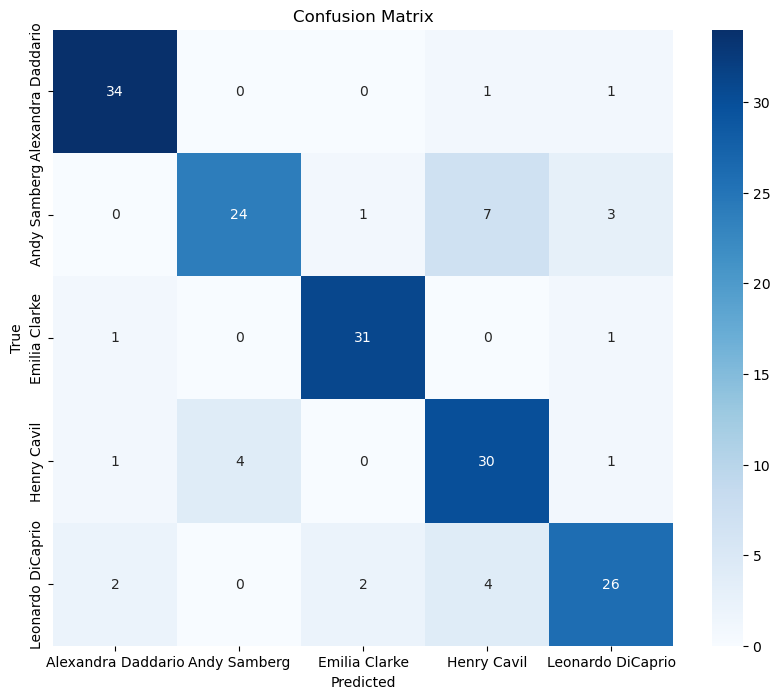

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')